In [253]:
# Importar librarias utilizadas

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler

from torch.utils.data import Dataset

from datetime import datetime, timedelta

from copy import deepcopy as dc 

from torch.utils.data import DataLoader



In [254]:
# Definir intervalo de tempo utilizado

# Sets the time of the events // Apenas quero uma semana
# Alterar timedelta para alterar linha temporal

current_time = datetime.now() # Data de hoje
seven_days_ago = current_time - timedelta(days=7) # data da semana passada

# Colocar no formato indicado
seven_days_ago = seven_days_ago.strftime("%Y-%m-%d") # Colocar no formato Ano-Mês-Dia
current_time = datetime.today().strftime('%Y-%m-%d') # Colocar no formato Ano-Mês-Dia
current_time, seven_days_ago

('2025-03-05', '2025-02-26')

In [255]:
# Utilizar yfinance para recolher os dados da Apple consoante a timeline dada
#data = yf.download("AAPL", start=seven_days_ago, end=current_time)

data = yf.download(tickers='AAPL',start=seven_days_ago, end=current_time, \
                   interval="1m") # Desnecessário usar o start= , end= \
                    # Pois com o period= e interval= ele já sabe, mas por data fixa para estudo
                    # Apenas para manter os dados consistentes na pesquisa 

data_hoje = yf.download(tickers='AAPL', start='2025-03-05', interval='1m')

data = pd.concat([data, data_hoje])

data.reset_index(inplace=True) # Reajusta a tabela para a 'Datetime' ficar no sítio

# Caso o DataFrame tenha um MultiIndex, que é o caso, remover os níveis extras
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)  # Remove o primeiro nível do índice

# Apenas ver Datetime e Close Price
data = data[['Datetime', 'Close']] # Datetime em vez de Date, pois é em minutos e não dias
data_futuro=data[-len(data_hoje):]
data=data[:-len(data_hoje)]
data, data_futuro

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


(Price                  Datetime       Close
 0     2025-02-26 14:30:00+00:00  243.669998
 1     2025-02-26 14:31:00+00:00  243.470001
 2     2025-02-26 14:32:00+00:00  243.604996
 3     2025-02-26 14:33:00+00:00  243.320007
 4     2025-02-26 14:34:00+00:00  243.455002
 ...                         ...         ...
 1934  2025-03-04 20:55:00+00:00  236.029999
 1935  2025-03-04 20:56:00+00:00  235.904999
 1936  2025-03-04 20:57:00+00:00  236.038696
 1937  2025-03-04 20:58:00+00:00  235.990005
 1938  2025-03-04 20:59:00+00:00  236.070007
 
 [1939 rows x 2 columns],
 Price                  Datetime       Close
 1939  2025-03-05 14:30:00+00:00  235.867996
 1940  2025-03-05 14:31:00+00:00  234.840103
 1941  2025-03-05 14:32:00+00:00  235.160004
 1942  2025-03-05 14:33:00+00:00  235.639999
 1943  2025-03-05 14:34:00+00:00  235.119995
 ...                         ...         ...
 2004  2025-03-05 15:35:00+00:00  232.380005
 2005  2025-03-05 15:36:00+00:00  232.229996
 2006  2025-03-05 15:37:00+

In [256]:
# Diz para usar GPU caso exista, se não existir, usar CPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' 
device

'cpu'

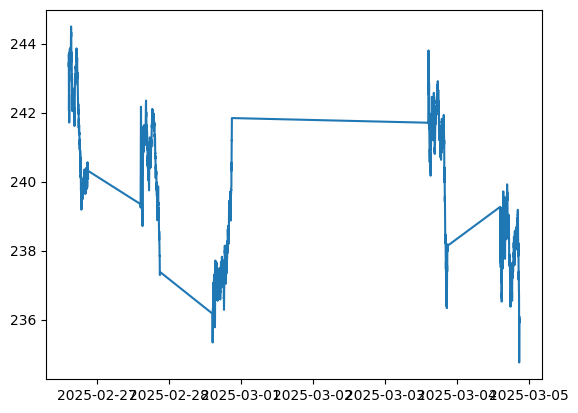

In [257]:
# Fazer o plot do gráfico

plt.plot(data['Datetime'], data['Close'])

In [258]:
#####################################################################
#   TER EM CONTA QUE HÁ PONTOS ONDE O INTERVALO DE TEMPO É MAIOR    #
#   ISTO ACONTECE QUANDO O MERCADO FECHA!                           #
#####################################################################

In [259]:
# Copiar os closings prices da hora anterior, minuto a minuto e associa-os à hora mais recente
# Como é de minuto a minuto, ao ter n steps = 60, copiamos uma hora atrás
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Datetime', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    
    df.dropna(inplace=True)

    return df
# 60 minutos para copiar uma hora
lookback = 60
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

Price,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),...,Close(t-51),Close(t-52),Close(t-53),Close(t-54),Close(t-55),Close(t-56),Close(t-57),Close(t-58),Close(t-59),Close(t-60)
Datetime,,,,,,,,,,,,,,,,,,,,,
2025-02-26 15:30:00+00:00,243.669998,243.479996,243.464996,243.600006,243.755005,243.550003,243.800003,244.169998,244.279999,244.330002,...,242.434998,242.520004,242.369995,242.059998,242.940002,243.455002,243.320007,243.604996,243.470001,243.669998
2025-02-26 15:31:00+00:00,243.580002,243.669998,243.479996,243.464996,243.600006,243.755005,243.550003,243.800003,244.169998,244.279999,...,242.000000,242.434998,242.520004,242.369995,242.059998,242.940002,243.455002,243.320007,243.604996,243.470001
2025-02-26 15:32:00+00:00,243.345001,243.580002,243.669998,243.479996,243.464996,243.600006,243.755005,243.550003,243.800003,244.169998,...,242.154999,242.000000,242.434998,242.520004,242.369995,242.059998,242.940002,243.455002,243.320007,243.604996
2025-02-26 15:33:00+00:00,243.199997,243.345001,243.580002,243.669998,243.479996,243.464996,243.600006,243.755005,243.550003,243.800003,...,241.710007,242.154999,242.000000,242.434998,242.520004,242.369995,242.059998,242.940002,243.455002,243.320007
2025-02-26 15:34:00+00:00,243.045807,243.199997,243.345001,243.580002,243.669998,243.479996,243.464996,243.600006,243.755005,243.550003,...,241.850006,241.710007,242.154999,242.000000,242.434998,242.520004,242.369995,242.059998,242.940002,243.455002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-04 20:55:00+00:00,236.029999,235.860001,235.279999,234.755005,235.059998,235.419998,236.639999,236.789993,236.809692,236.979996,...,238.509995,238.684998,238.403595,238.309998,238.389999,238.190002,238.162003,238.110001,238.035004,238.111099
2025-03-04 20:56:00+00:00,235.904999,236.029999,235.860001,235.279999,234.755005,235.059998,235.419998,236.639999,236.789993,236.809692,...,238.270004,238.509995,238.684998,238.403595,238.309998,238.389999,238.190002,238.162003,238.110001,238.035004
2025-03-04 20:57:00+00:00,236.038696,235.904999,236.029999,235.860001,235.279999,234.755005,235.059998,235.419998,236.639999,236.789993,...,238.535004,238.270004,238.509995,238.684998,238.403595,238.309998,238.389999,238.190002,238.162003,238.110001


In [260]:
# Colocar valores do dataframe em array de numpy (shifted_df_as_np)
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[243.66999817, 243.47999573, 243.46499634, ..., 243.60499573,
        243.47000122, 243.66999817],
       [243.58000183, 243.66999817, 243.47999573, ..., 243.32000732,
        243.60499573, 243.47000122],
       [243.34500122, 243.58000183, 243.66999817, ..., 243.45500183,
        243.32000732, 243.60499573],
       ...,
       [236.03869629, 235.90499878, 236.02999878, ..., 238.19000244,
        238.16200256, 238.11000061],
       [235.99000549, 236.03869629, 235.90499878, ..., 238.38999939,
        238.19000244, 238.16200256],
       [236.07000732, 235.99000549, 236.03869629, ..., 238.30999756,
        238.38999939, 238.19000244]], shape=(1879, 61))

In [261]:
# Colocar shifted_df_as_np em valores que o computador entenda, valores ente -1 e 1, usando MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[ 0.95826413,  0.91652827,  0.91323351, ...,  0.80567674,
         0.77620192,  0.81986943],
       [ 0.93849557,  0.95826413,  0.91652827, ...,  0.74345212,
         0.80567674,  0.77620192],
       [ 0.88687542,  0.93849557,  0.95826413, ...,  0.77292694,
         0.74345212,  0.80567674],
       ...,
       [-0.71802482, -0.74739277, -0.71993531, ..., -0.3766377 ,
        -0.38275122, -0.39410537],
       [-0.72872022, -0.71802482, -0.74739277, ..., -0.33297019,
        -0.3766377 , -0.38275122],
       [-0.71114705, -0.72872022, -0.71802482, ..., -0.35043786,
        -0.33297019, -0.3766377 ]], shape=(1879, 61))

In [262]:
# Separar variáveis independentes (x) e variável alvo (y)
# x são todos os preços na hora anterior a cada elemento de y e y é a lista de closing prices
x = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

x.shape, y.shape

((1879, 60), (1879,))

In [263]:
# Inverter a ordem dos passos de tempo
# Senão ele estaria a fazer do recente para o antigo e não ao contrário
# o que iria distorcer os resultados
x = dc(np.flip(x, axis=1))
x

array([[ 0.81986943,  0.77620192,  0.80567674, ...,  0.9428897 ,
         0.91323351,  0.91652827],
       [ 0.77620192,  0.80567674,  0.74345212, ...,  0.91323351,
         0.91652827,  0.95826413],
       [ 0.80567674,  0.74345212,  0.77292694, ...,  0.91652827,
         0.95826413,  0.93849557],
       ...,
       [-0.39410537, -0.38275122, -0.3766377 , ..., -0.75727705,
        -0.71993531, -0.74739277],
       [-0.38275122, -0.3766377 , -0.33297019, ..., -0.71993531,
        -0.74739277, -0.71802482],
       [-0.3766377 , -0.33297019, -0.35043786, ..., -0.74739277,
        -0.71802482, -0.72872022]], shape=(1879, 60))

In [264]:
# Ver quantos dados dados de treino (90%) e de teste (10%)
split_index = int(len(x) * 0.9)
split_index

1691

In [265]:
# Separar os dados em treino (90%) e teste (10%)

x_train = x[:split_index]   # x de 0 a 90%
x_test = x[split_index:]    # x de 90% a 100%

y_train =y[:split_index]    # y de 0 a 90%
y_test = y[split_index:]    # y de 90% a 100%

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1691, 60), (188, 60), (1691,), (188,))

In [266]:
# Reformatar para entrada no modelo (batch_size, sequência, features)

x_train = x_train.reshape((-1, lookback, 1))
x_test = x_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1691, 60, 1), (188, 60, 1), (1691, 1), (188, 1))

In [267]:
# Converter arrays NumPy para tensores PyTorch

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([1691, 60, 1]),
 torch.Size([188, 60, 1]),
 torch.Size([1691, 1]),
 torch.Size([188, 1]))

In [268]:
# Criar classe de dataset para PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

train_dataset = TimeSeriesDataset(x_train, y_train)
test_dataset = TimeSeriesDataset(x_test, y_test)


In [269]:
# Criar DataLoaders para treino e teste

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [270]:
# Testar forma dos batches de treino
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 60, 1]) torch.Size([32, 1])


In [271]:
# Definir modelo LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 100, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [272]:
# Função para treinar uma época de dados
def train_one_epoch():
    model.train(True)  # Set model to training mode
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    # Iterate through batches in the training set
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)  # Forward pass
        loss = loss_function(output, y_batch)  # Compute loss
        running_loss += loss.item()

        optimizer.zero_grad()  # Zero gradients before backward pass
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        # Print loss every 100 batches
        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index + 1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [273]:
# Function to validate the model after each epoch
def validate_one_epoch():
    model.train(False)  # Set model to evaluation mode
    running_loss = 0.0

    # Iterate through batches in the test set
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():  # Disable gradient calculation for validation
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [274]:
# Set learning parameters
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


In [275]:
# Train and validate model
for epoch in range(num_epochs):
    train_one_epoch()
    val_loss = validate_one_epoch()
    if val_loss is not None:
        scheduler.step(val_loss)

Epoch: 1

Val Loss: 0.010
***************************************************

Epoch: 2

Val Loss: 0.008
***************************************************

Epoch: 3

Val Loss: 0.007
***************************************************

Epoch: 4

Val Loss: 0.006
***************************************************

Epoch: 5

Val Loss: 0.006
***************************************************

Epoch: 6

Val Loss: 0.005
***************************************************

Epoch: 7

Val Loss: 0.006
***************************************************

Epoch: 8

Val Loss: 0.005
***************************************************

Epoch: 9

Val Loss: 0.004
***************************************************

Epoch: 10

Val Loss: 0.004
***************************************************

Epoch: 11

Val Loss: 0.004
***************************************************

Epoch: 12

Val Loss: 0.004
***************************************************

Epoch: 13

Val Loss: 0.004
**********************

In [276]:
print(y_train)

tensor([[ 0.9583],
        [ 0.9385],
        [ 0.8869],
        ...,
        [-0.4168],
        [-0.4311],
        [-0.4629]])


In [277]:
with torch.no_grad():
    predicted = model(x_train.to(device)).to('cpu').numpy()

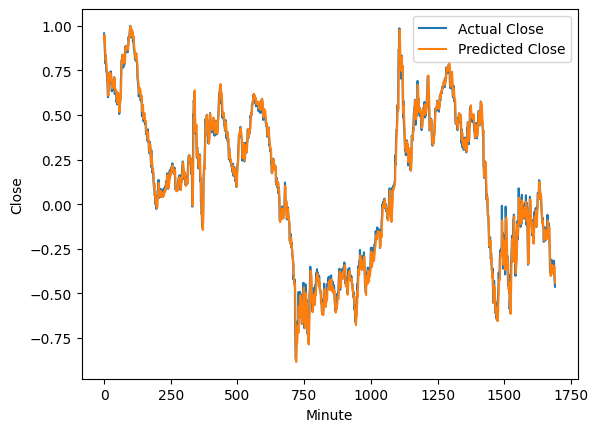

In [278]:
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Minute')
plt.ylabel('Close')
plt.legend()
plt.show()

In [279]:
train_predictions = predicted.flatten()

dummies = np.zeros((x_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([243.49713047, 243.61755073, 243.6142522 , ..., 237.68773566,
       237.44328389, 237.30132428], shape=(1691,))

In [280]:
dummies = np.zeros((x_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

/tmp/ipykernel_33663/2743067881.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  dummies[:, 0] = y_train.flatten()


array([243.66999807, 243.58000185, 243.34500134, ..., 237.41000363,
       237.34500119, 237.19999689], shape=(1691,))

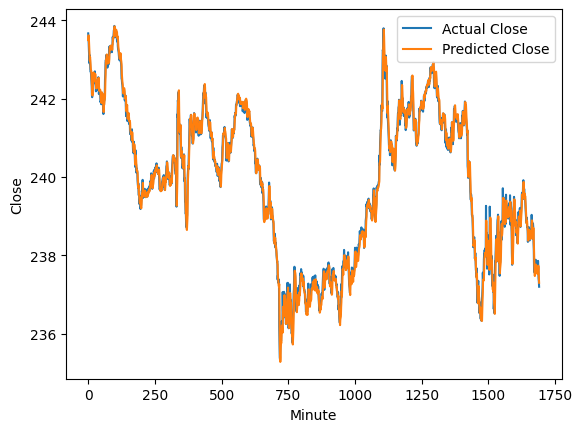

In [281]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Minute')
plt.ylabel('Close')
plt.legend()
plt.show()

In [282]:
test_predictions = model(x_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([237.16050339, 236.93625933, 236.74890164, 236.42149858,
       236.58496878, 236.68330521, 236.675     , 236.62226638,
       236.61729797, 236.42352529, 236.46477918, 236.5539684 ,
       236.45849607, 236.3460573 , 236.53256404, 236.50630712,
       236.59860249, 236.53620094, 236.41917826, 236.69938189,
       236.87947961, 237.12814083, 237.26698548, 237.35833194,
       237.49997339, 237.56111343, 237.50964932, 237.30051552,
       237.12690497, 237.03550913, 237.0465102 , 237.07413173,
       237.10785769, 237.00641064, 236.92257053, 236.83711509,
       236.76769751, 236.59093794, 236.54108307, 236.65341954,
       236.67237442, 236.53534429, 236.71469905, 236.99508259,
       237.18898999, 237.24003377, 237.16722799, 237.13671671,
       237.1682096 , 237.22410919, 237.21682249, 237.20942983,
       237.21301898, 237.24931707, 237.27507375, 237.30630152,
       237.24733797, 237.21361961, 237.46474239, 237.44735618,
       237.38114962, 237.33224842, 237.43410684, 237.42

In [283]:
dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

/tmp/ipykernel_33663/973696869.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  dummies[:, 0] = y_test.flatten()


array([236.93879699, 236.77999889, 236.38000482, 236.80000309,
       236.80290219, 236.74000543, 236.67570497, 236.69999704,
       236.41000365, 236.58999635, 236.67500299, 236.47999567,
       236.38000482, 236.71670542, 236.55000316, 236.72000123,
       236.57000736, 236.44500726, 236.92500292, 237.00500477,
       237.28500366, 237.3600006 , 237.44000246, 237.61000067,
       237.63000486, 237.53999331, 237.27999875, 237.14999387,
       237.10000604, 237.14999387, 237.1699982 , 237.19999689,
       237.03370668, 236.97500621, 236.88999931, 236.8296052 ,
       236.60000619, 236.62499996, 236.80000309, 236.75000006,
       236.54499811, 236.89500436, 237.1799927 , 237.30999758,
       237.30000308, 237.19000239, 237.19999689, 237.25999455,
       237.32000727, 237.27999875, 237.27999875, 237.28999325,
       237.33999627, 237.35629274, 237.38999943, 237.28999325,
       237.27999875, 237.65499877, 237.47999579, 237.41999813,
       237.38999943, 237.55969237, 237.47999579, 237.53

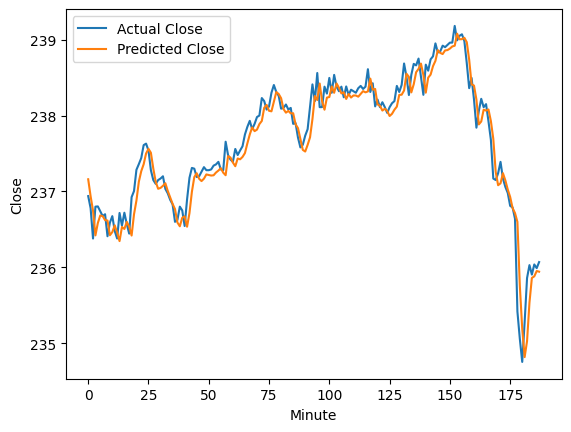

In [284]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Minute')
plt.ylabel('Close')
plt.legend()
plt.show()

In [285]:
test_predictions = model(x_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions


dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

/tmp/ipykernel_33663/2457523599.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  dummies[:, 0] = y_test.flatten()


array([236.93879699, 236.77999889, 236.38000482, 236.80000309,
       236.80290219, 236.74000543, 236.67570497, 236.69999704,
       236.41000365, 236.58999635, 236.67500299, 236.47999567,
       236.38000482, 236.71670542, 236.55000316, 236.72000123,
       236.57000736, 236.44500726, 236.92500292, 237.00500477,
       237.28500366, 237.3600006 , 237.44000246, 237.61000067,
       237.63000486, 237.53999331, 237.27999875, 237.14999387,
       237.10000604, 237.14999387, 237.1699982 , 237.19999689,
       237.03370668, 236.97500621, 236.88999931, 236.8296052 ,
       236.60000619, 236.62499996, 236.80000309, 236.75000006,
       236.54499811, 236.89500436, 237.1799927 , 237.30999758,
       237.30000308, 237.19000239, 237.19999689, 237.25999455,
       237.32000727, 237.27999875, 237.27999875, 237.28999325,
       237.33999627, 237.35629274, 237.38999943, 237.28999325,
       237.27999875, 237.65499877, 237.47999579, 237.41999813,
       237.38999943, 237.55969237, 237.47999579, 237.53

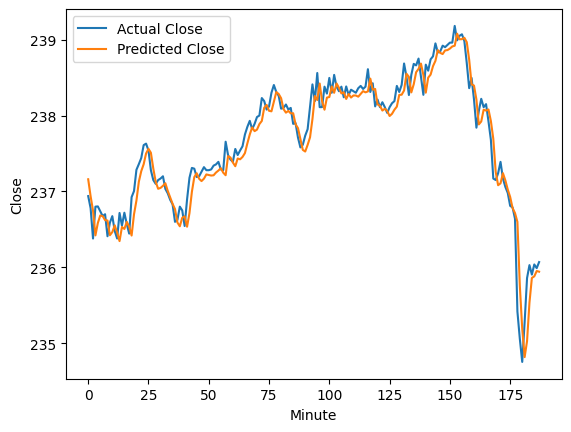

In [286]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Minute')
plt.ylabel('Close')
plt.legend()
plt.show()


/tmp/ipykernel_33663/3149563071.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  future_inputs_tensor = torch.tensor(future_inputs.reshape(1, lookback, 1)).float().to(device)


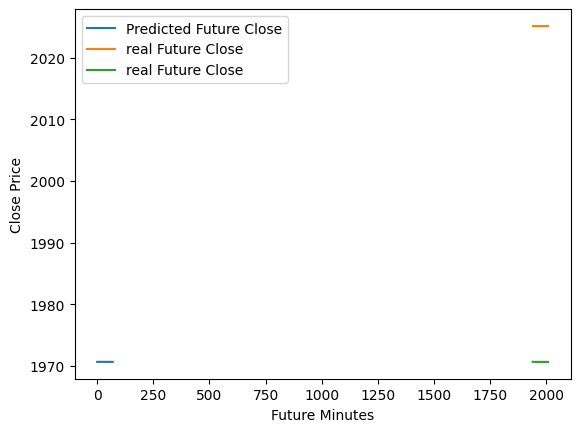

In [292]:
# Definir número de minutos futuros que queremos prever
N = len(data_futuro)  # Exemplo: prever os próximos 60 minutos

# Pegar os últimos 'lookback' minutos do conjunto de testes como ponto de partida
future_inputs = dc(x_test[-1])  # Última sequência do conjunto de testes
future_predictions = []

# Gerar previsões iterativas
for _ in range(N):
    future_inputs_tensor = torch.tensor(future_inputs.reshape(1, lookback, 1)).float().to(device)
    
    with torch.no_grad():
        predicted_value = model(future_inputs_tensor).cpu().numpy().flatten()[0]
    
    # Adicionar previsão à lista
    future_predictions.append(predicted_value)

    # Atualizar a sequência de entrada (deslocar para incluir o novo valor)
    future_inputs = np.roll(future_inputs, -1)
    future_inputs[-1] = predicted_value  # Adiciona a nova previsão no final

# Inverter a normalização para trazer os valores à escala original
dummies = np.zeros((N, lookback+1))
dummies[:, 0] = future_predictions
dummies = scaler.inverse_transform(dummies)

future_predictions = dummies[:, 0]

# Plotar previsões futuras
plt.plot(future_predictions, label='Predicted Future Close')
plt.plot(data_futuro, label='real Future Close')
plt.xlabel('Future Minutes')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [288]:
##############################
# Tentar implementar as news #
##############################

In [289]:
stock_symbol = "AAPL"  # Pode ser qualquer ação
ticker = yf.Ticker(stock_symbol)


# Recebe as 10 notícias mais recentes
news = ticker.news 


for article in news:
    if (int(article['content']['pubDate'][8:10]) == datetime.today().day \
    or int(article['content']['pubDate'][8:10]) == datetime.today().day - 1) \
    and int(article['content']['pubDate'][5:7]) == datetime.today().month \
    and int(article['content']['pubDate'][:4]) == datetime.today().year:
        print(f"Data publicação: {article['content']['pubDate']}")
        print(f"Título: {article['content']['title']}")
        print(article['content']['summary'])
        print(f"URL: {article['content']['canonicalUrl']['url']}")

    print("-" * 50)

#ticker.actions
#ticker.financials

Data publicação: 2025-03-05T14:49:33Z
Título: How Big Tech is trying to win over Trump
Big Tech is trying to navigate the second Trump administration.
URL: https://finance.yahoo.com/news/how-big-tech-is-trying-to-win-over-trump-200058642.html
--------------------------------------------------
Data publicação: 2025-03-05T14:05:43Z
Título: Apple launches new MacBook Air models with latest M4 chip, cuts price
The base version of the new series of laptops with the 13-inch screen will be priced at $999, while the 15-inch MacBook Air will start at $1,199.  Apple Intelligence is a set of features with access to ChatGPT that allows users to write emails, messages and edit photos among other capabilities.  The suite of AI features debuted on Apple's iPhone devices late last year, and the company has been rolling out the tools in various languages and regions to capture more users.
URL: https://finance.yahoo.com/news/apple-launches-macbook-air-models-140543557.html
------------------------------

In [290]:
# Criar um DataFrame com as notícias e datas
news_data = []
for article in news:
    display_time = article['content'].get('displayTime', '')  # Evita KeyError
    try:
        date_parsed = datetime.strptime(display_time, "%Y-%m-%dT%H:%M:%SZ") if display_time else None
    except ValueError:
        date_parsed = None  # Caso a string tenha um formato inválido
    if date_parsed != None:
        news_data.append({
            "title": article['content']["title"],
            "link": article['content']['canonicalUrl']['url'],
            "content": article['content']['summary'],
            "date": date_parsed,  # Converter string para datetime
            "publisher": article['content']['provider']['displayName']
        })

news_df = pd.DataFrame(news_data)
print(news_df.head())
news_df


                                               title  \
0           How Big Tech is trying to win over Trump   
1  Apple launches new MacBook Air models with lat...   
2  Apple Inc. (AAPL): Among Best Stocks To Invest...   
3  This Once-Unstoppable Low-Cost Vanguard ETF Is...   
4  Will Warren Buffett-Led Berkshire Hathaway Joi...   

                                                link  \
0  https://finance.yahoo.com/news/how-big-tech-is...   
1  https://finance.yahoo.com/news/apple-launches-...   
2  https://finance.yahoo.com/news/apple-inc-aapl-...   
3  https://www.fool.com/investing/2025/03/05/buy-...   
4  https://www.fool.com/investing/2025/03/05/buff...   

                                             content                date  \
0  Big Tech is trying to navigate the second Trum... 2025-03-05 14:49:33   
1  The base version of the new series of laptops ... 2025-03-05 14:05:43   
2  We recently published a list of Conservative S... 2025-03-05 11:24:22   
3  Technology stocks l

,title,link,content,date,publisher
0,How Big Tech is trying to win over Trump,https://finance.yahoo.com/news/how-big-tech-is...,Big Tech is trying to navigate the second Trum...,2025-03-05 14:49:33,Yahoo Finance
1,Apple launches new MacBook Air models with lat...,https://finance.yahoo.com/news/apple-launches-...,The base version of the new series of laptops ...,2025-03-05 14:05:43,Reuters
2,Apple Inc. (AAPL): Among Best Stocks To Invest...,https://finance.yahoo.com/news/apple-inc-aapl-...,We recently published a list of Conservative S...,2025-03-05 11:24:22,Insider Monkey
3,This Once-Unstoppable Low-Cost Vanguard ETF Is...,https://www.fool.com/investing/2025/03/05/buy-...,"Technology stocks like Nvidia (NASDAQ: NVDA), ...",2025-03-05 11:24:00,Motley Fool
4,Will Warren Buffett-Led Berkshire Hathaway Joi...,https://www.fool.com/investing/2025/03/05/buff...,Berkshire Hathaway (NYSE: BRK.A) (NYSE: BRK.B)...,2025-03-05 10:25:00,Motley Fool
5,Nvidia AI Server Maker Hon Hai Posts 25% Jump ...,https://finance.yahoo.com/news/nvidia-ai-serve...,(Bloomberg) -- Hon Hai Precision Industry Co. ...,2025-03-05 07:50:11,Bloomberg
6,Foxconn says February revenue rose 56.43% y/y,https://finance.yahoo.com/news/foxconn-says-fe...,"Taiwan's Foxconn, the world's largest contract...",2025-03-05 07:44:33,Reuters
7,Apple Inc. (AAPL): Among the Best Stocks To In...,https://finance.yahoo.com/news/apple-inc-aapl-...,We recently compiled a list of the 30 Best Sto...,2025-03-05 05:15:48,Insider Monkey
8,Jim Cramer on Apple Inc. (AAPL): ‘If We Slap S...,https://finance.yahoo.com/news/jim-cramer-appl...,We recently compiled a list of the Jim Cramer ...,2025-03-04 22:18:52,Insider Monkey
9,Apple Isn't Priced for Tariff Showdown: Heard ...,https://www.wsj.com/livecoverage/trump-tariffs...,"When it comes to the new trade war, Apple inve...",2025-03-04 21:24:33,The Wall Street Journal


In [291]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# Aplicar análise de sentimento
#news_df["sentiment"] = (news_df["title"].apply(lambda title: sia.polarity_scores(title)["compound"]) + \
#                        news_df["content"].apply(lambda content: sia.polarity_scores(content)["compound"])) / len(news_df)
news_df["sentiment"] = (news_df["title"].apply(lambda title: sia.polarity_scores(title)["compound"]))
news_df["sentimento_qualitativo"] = "Neutral"
for i in range(news_df.shape[0]):
    if (news_df.loc[i]["sentiment"] >= -0.1) and (news_df.loc[i]["sentiment"] < 0.1):
        news_df["sentimento_qualitativo"][i] = "Neutral"
    elif 0.1 < news_df.loc[i]["sentiment"] < 0.5:
        news_df["sentimento_qualitativo"][i] = "Buy"
    elif 0.5 < news_df.loc[i]["sentiment"] <= 1:
        news_df["sentimento_qualitativo"][i] = "Strong Buy"
    elif -0.5 <= news_df.loc[i]["sentiment"] < -0.1:
        news_df["sentimento_qualitativo"][i] = "Sell"
    elif -1 <= news_df.loc[i]["sentiment"] < -0.5:
        news_df["sentimento_qualitativo"][i] = "Strong Sell"


#print(news_df[["title", "content", "sentiment"]].head())
#sum(news_df['sentiment'])
news_df



ModuleNotFoundError: No module named 'nltk'

In [ ]:
# Arredondar a data para remover horas e minutos
news_df["date"] = news_df["date"].dt.date

# Arredondar também no dataset de preços
data["Datetime"] = data["Datetime"].dt.date

# Calcular sentimento médio por dia
daily_sentiment = news_df.groupby("date")["sentiment"].mean()

# Adicionar sentimento ao dataset de preços
data = data.merge(daily_sentiment, left_on="Date", right_index=True, how="left")

# Preencher valores ausentes com 0 (caso não tenha notícias em um dia)
data["sentiment"].fillna(0, inplace=True)

print(data.head())
data